The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
	At this point, it's okay to detect edges around trees or cars because these lines can be mostly filtered out by applying a mask to the image and essentially cropping out the area outside of the lane lines. It's most important that you reliably detect different colors of lane lines under varying degrees of daylight and shadow.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
	A perspective transform maps the points in a given image to different, desired, image points with a new perspective. The perspective transform you’ll be most interested in is a bird’s-eye view transform that let’s us view a lane from above; this will be useful for calculating the lane curvature later on. Aside from creating a bird’s eye view representation of an image, a perspective transform can also be used for all kinds of different view points.
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called ouput_images, and include a description in your writeup for the project of what each image shows. The video called project_video.mp4 is the video your pipeline should work well on.


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


def doCameraCalibration():

    #read in calibration 

    images = glob.glob('./camera_cal/calibration*.jpg')


    chessboard_size = (chessboard_x*chessboard_y, 3)

    objp = np.zeros(chessboard_size, np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_x, 0:chessboard_y].T.reshape(-1, 2) #fills out the objp with correct entries (before this line just zeros, now e.g. array([[ 0.,  0.,  0.], [ 1.,  0.,  0.], [ 


    for fname in images:
        img = mpimg.imread(fname)
        #convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        #Finding chessboard corners for an (chessboard_x,chessboard_y) board:
        ret, corners = cv2.findChessboardCorners(gray, (chessboard_x,chessboard_y),None)

        if ret == True: 
            imgpoints.append(corners)
            objpoints.append(objp)

            #draw and display corners
            img = cv2.drawChessboardCorners(img, (chessboard_x,chessboard_y), corners, ret)
#             plt.imshow(img)
#             plt.show()
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)




In [3]:
# function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image

def cal_undistort(img, objpoints, imgpoints):
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    #undist = np.copy(img)  # Delete this line
    return undist



In [4]:
def color_and_gradient_threshold(undistorted):
    ## COLOR THRESHOLD AND GRADIENT THRESHOLD:
    #https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/a1b70df9-638b-46bb-8af0-12c43dcfd0b4

    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
    # plt.imshow(gray,cmap='gray')
    # plt.show()

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x

    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal

    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)

    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel (to threshold colors for lanes)
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1


    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

##### Apply the transform code


The easiest way to do this is to investigate an image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.
https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/e6e02d4d-7c80-4bed-a79f-869ef496831b


Note: When you apply a perspective transform, choosing four source points manually, as we did in this video, is often not the best option. There are many other ways to select source points. For example, many perspective transform algorithms will programmatically detect four source points in an image based on edge or corner detection and analyzing attributes like color and surrounding pixels.


In [5]:

# src_upper_right = (703, 461)
# src_lower_right = (1093, 715)
# src_lower_left= (220, 715)
# src_upper_left= (580,461)

src_upper_right = (703, 461)
src_lower_right = (1093, 715)
src_lower_left= (220, 715)
src_upper_left= (580,461)

# Choose offset from image corners to plot detected corners
# This should be chosen to present the result at the proper aspect ratio
# My choice of 100 pixels is not exact, but close enough for our purpose here

# offset for dst points
offset_leftx = 200 
offset_rightx = 300 

global transform_offset_rightx, transform_offset_leftx 
transform_offset_rightx = src_lower_right[0]-(img.shape[1]-offset_rightx)
#Example 1093 - (1280-300) = 113 --> so example x coordinate in transform of 800 represents x coordinate in original image of 913 
transform_offset_leftx = src_lower_left[0]-(offset_leftx)




# Define a function that takes an undistorted, color thresholded and gradient thresholded image, and transform it.
def unwarp(undist):

    img_size = (img.shape[1], img.shape[0])

    # For source points I'm grabbing the outer four detected corners
    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
#     src = np.float32([src_upper_right, src_lower_right, src_lower_left, src_upper_left])
    
    src = np.float32([src_upper_right, src_lower_right, src_lower_left, src_upper_left])
#     src = np.float32([src_upper_left, src_upper_right, src_lower_right, src_lower_left])

    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    #print(img_size[0]) #1280
  
    dst = np.float32([[img_size[0]-offset_rightx, 0], [img_size[0]-offset_rightx, img_size[1]], [offset_leftx, img_size[1]], 
                                 [offset_leftx,0]])



    


    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
#     warped = cv2.warpPerspective(undist, M, img_size)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)


    # Return the resulting image and matrix
    return warped, M, Minv

NameError: name 'img' is not defined

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_polynomial(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img_red = np.copy(out_img)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # At this point, you're done! But here is how you can visualize the result as well:
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    out_img_red[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img_red[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, out_img_red, left_fit, left_fitx, leftx,lefty, right_fit, right_fitx, rightx, righty, ploty

In [6]:
def update_polynomial(binary_warped, left_fit, right_fit):

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  


    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
   
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #VISUALIZE
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img_red = np.copy(out_img)
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    out_img_red[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img_red[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#     plt.imshow(result)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    
    return result, out_img_red, left_fit, left_fitx, leftx,lefty, right_fit, right_fitx, rightx, righty, ploty

In [16]:
def left_right_curverad(left_fit, leftx, lefty, right_fit, rightx, righty, ploty):

#This involves measuring how long and wide the section of lane is that we're projecting in our warped image. 
#We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this 
#project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 
#30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your
#own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters,
#and the dashed lane lines are 10 feet or 3 meters long each.

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
# #     print('ploty', ploty)
#     print('yeval', y_eval)

#     print('left fit, ', left_fit)
#     print('leftx, ', leftx)


    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension


#     Ploty,  720
#     leftx,  38711

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
   
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
  
    global transform_offset_rightx, transform_offset_leftx 

    lane_center = ((right_fitx[-1]+transform_offset_rightx)+(left_fitx[-1]+transform_offset_leftx))/2
    center_of_image = undistorted.shape[1]/2
    
    offset_from_lane_center = (lane_center-center_of_image)*xm_per_pix
    
#     print("left_fitx -1 : ", left_fitx[-1])
#     print("right_fitx -1: ", right_fitx[-1])
#     print("center of image: ", center_of_image)
#     print("lane_center ", lane_center)
#     print("transform elft x ", transform_offset_leftx)
#     print("transform right x ", transform_offset_rightx)

#     print("off ", offset_from_lane_center)

# #     #1280
# #     1093 --> 980
# #     220 --> 200


    
    return round(left_curverad/1000,2), round(right_curverad/1000,2), round(offset_from_lane_center,2)

    # Example values: 632.1 m    626.2 m

In [7]:
# def draw_lanes_on_original_img(undistorted,binary_warped,Minv,left_fitx, right_fitx, ploty):
def draw_lanes_on_original_img(undistorted,out_img,Minv,left_fitx, right_fitx, ploty):
    color_warp = np.copy(out_img)
#     # Create an image to draw the lines on
#     print(np.max(binary_warped))
#     print(binary_warped.shape)

#     warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
#     color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

#     print(np.max(color_warp))
#     print(color_warp.shape)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
#     newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
    


    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

#     result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return result

In [8]:
##MAIN 1 - do calibration
##Arrays to store object and image points from all the images 
#Prepare objpoints such as (0,0,0), (1,0,0), (2,0,0), objpoints are the same for all cal images 

objpoints = [] #3d real world space
imgpoints = [] #2d points in image spac

chessboard_x = 9
chessboard_y = 6

#Camera calibration, given object points, image points, and the shape of the grayscale image:
ret, mtx, dist, rvecs, tvecs = doCameraCalibration()


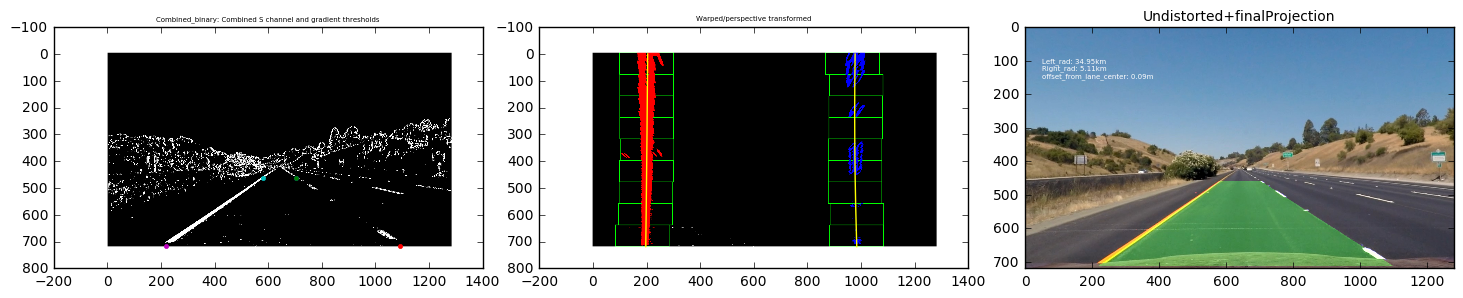

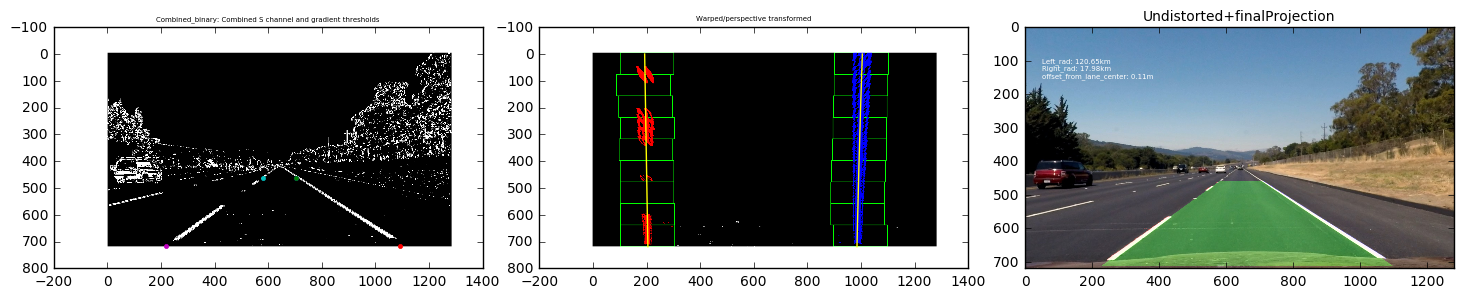

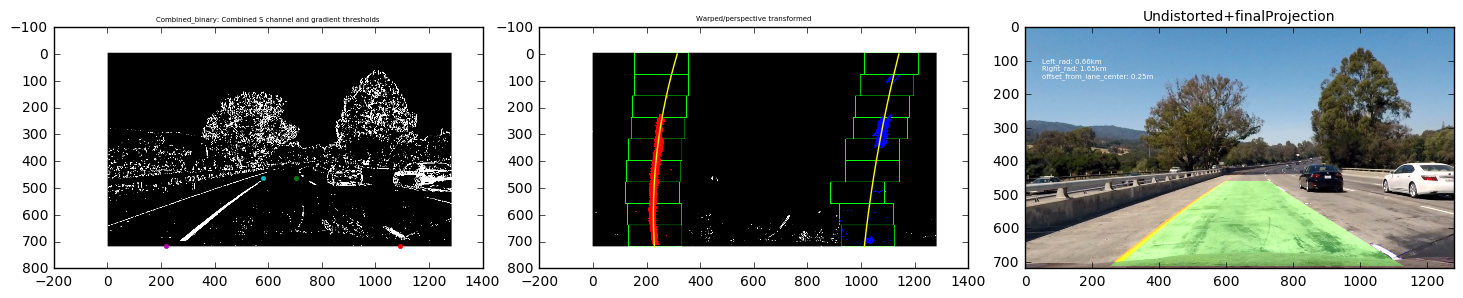

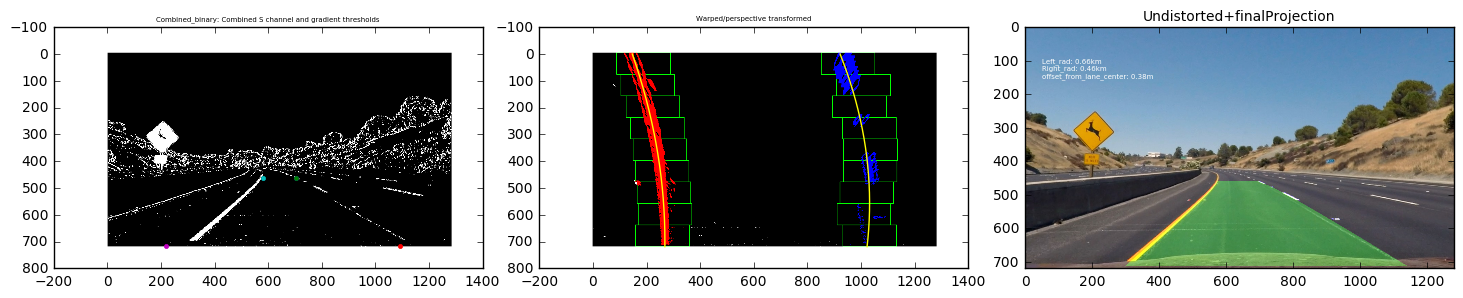

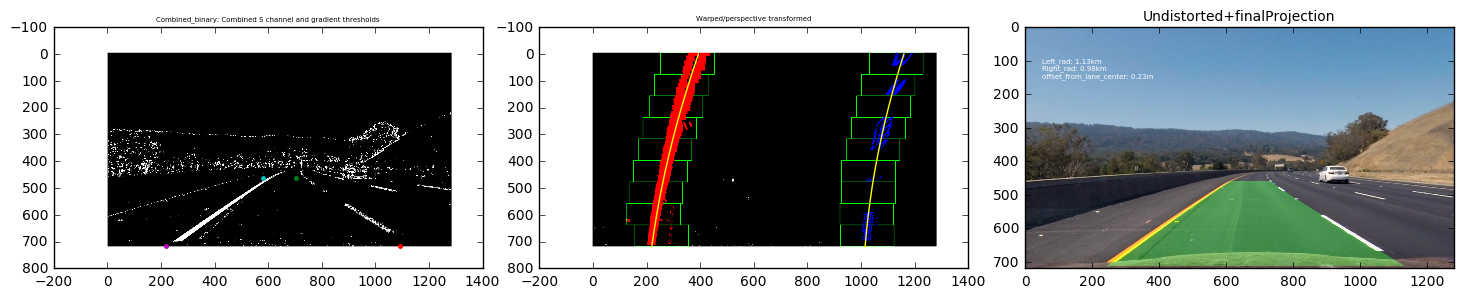

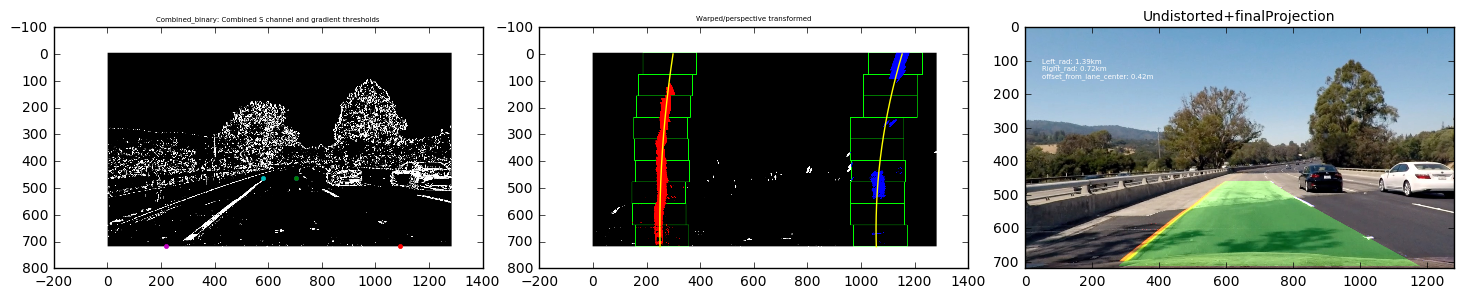

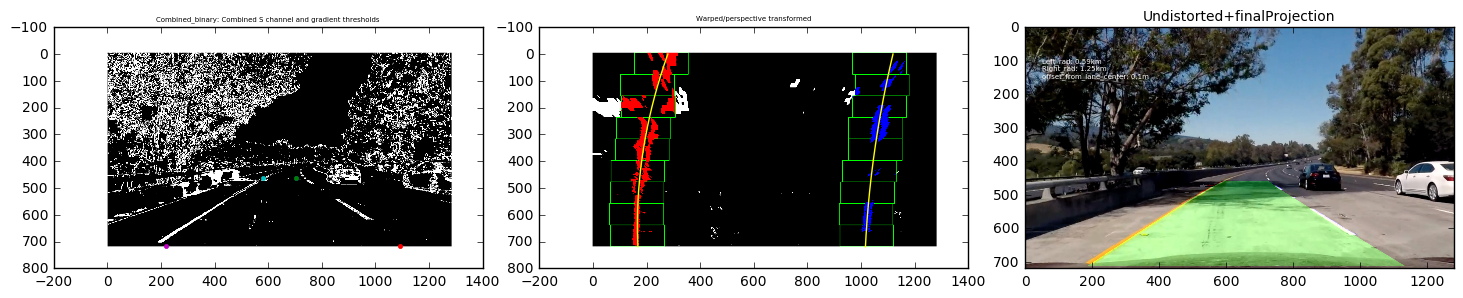

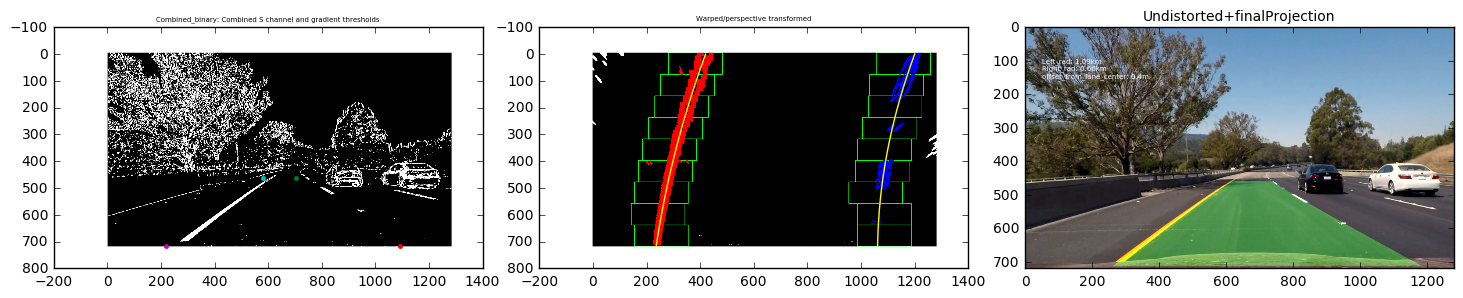

In [19]:
## MAIN 2 - run on test images
#img = mpimg.imread('./camera_cal/calibration1.jpg')
images = []
img = mpimg.imread('./test_images/straight_lines1.jpg')
images.append(img)
img1 = mpimg.imread('./test_images/straight_lines2.jpg')
images.append(img1)
img1 = mpimg.imread('./test_images/test1.jpg')
images.append(img1)
img1 = mpimg.imread('./test_images/test2.jpg')
images.append(img1)
img1 = mpimg.imread('./test_images/test3.jpg')
images.append(img1)
img1 = mpimg.imread('./test_images/test4.jpg')
images.append(img1)
img1 = mpimg.imread('./test_images/test5.jpg')
images.append(img1)
img1 = mpimg.imread('./test_images/test6.jpg')
images.append(img1)


initial_polynomials_found = False

for img in images:
    undistorted = cal_undistort(img, objpoints, imgpoints)
    combined_binary = color_and_gradient_threshold(undistorted)
    
    #perspective transform
    binary_warped, M, Minv = unwarp(combined_binary)
    
    ##you have to re-run the histograms filter since test images (and then resulting polynomials) don't depend on each other
    initial_polynomials_found = False

    if not initial_polynomials_found:
        #for first image define left and right polynomials of lanes (left_fit, right_fit). We will use those polynomials in the subsequent images
        out_img, out_img_red, left_fit, left_fitx, leftx, lefty, right_fit, right_fitx, rightx, righty, ploty= generate_polynomial(binary_warped)
        initial_polynomials_found = True

    else:
         out_img, out_img_red, left_fit, left_fitx, leftx, lefty, right_fit, right_fitx, rightx, righty, ploty = update_polynomial(binary_warped, left_fit, right_fit)
    
    
    left_curverad, right_curverad, offset_from_lane_center = left_right_curverad(left_fit, leftx, lefty, right_fit, rightx, righty, ploty)
#     print(left_curverad, 'm', right_curverad, 'm')

#     lanes_on_original = draw_lanes_on_original_img(undistorted,binary_warped,Minv,left_fitx, right_fitx, ploty)
    lanes_on_original = draw_lanes_on_original_img(undistorted,out_img_red,Minv,left_fitx, right_fitx, ploty)

    
    ##VISUALIZE
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))
    f.tight_layout()
# #     ax1.imshow(img)
# #     ax1.set_title('Original', fontsize=10)
    
    ax1.set_title('Combined_binary: Combined S channel and gradient thresholds', fontsize=5)
    ax1.imshow(combined_binary, cmap='gray')
    ax1.plot(src_upper_right[0],src_upper_right[1], '.')
    ax1.plot(src_upper_right[0],src_upper_right[1], '.')
    ax1.plot(src_lower_right[0],src_lower_right[1], '.')
    ax1.plot(src_upper_left[0],src_upper_left[1], '.')
    ax1.plot(src_lower_left[0],src_lower_left[1], '.')
    
    
    ax2.set_title('Warped/perspective transformed', fontsize=5)
    ax2.imshow(out_img)
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    
    curvatureString = "Left_rad: " + str(left_curverad) + 'km ' + '\nRight_rad: ' + str(right_curverad) + 'km' +'\noffset_from_lane_center: ' + str(offset_from_lane_center) + 'm'

#     ax3.imshow(undistorted)
    ax3.imshow(lanes_on_original)
    ax3.set_title('Undistorted+finalProjection', fontsize=10)
    ax3.text(50, 150, curvatureString, fontsize=5, color='white')

# #     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
            
# #     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    


Test on Videos

In [1]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from io import StringIO

# from cStringIO import StringIO


white_output = 'harder_challenge_video_annotated.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
# clip1 = VideoFileClip("project_video.mp4", audio=True).subclip(2,6)


initial_polynomials_found = False


def process_image(image):
    global initial_polynomials_found, left_fit, left_fitx, leftx, right_fit, right_fitx, rightx, ploty
    img = np.copy(image)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    combined_binary = color_and_gradient_threshold(undistorted)
    #perspective transform
    binary_warped, M, Minv = unwarp(combined_binary)
    
    initial_polynomials_found = False

    if not initial_polynomials_found:
        #for first image define left and right polynomials of lanes (left_fit, right_fit). We will use those polynomials in the subsequent images
        out_img, out_img_red, left_fit, left_fitx, leftx, lefty, right_fit, right_fitx, rightx, righty, ploty  = generate_polynomial(binary_warped)
        initial_polynomials_found = True

    else:
        out_img, out_img_red, left_fit, left_fitx, leftx, lefty, right_fit, right_fitx, rightx, righty, ploty = update_polynomial(binary_warped, left_fit, right_fit)
    
#     left_curverad, right_curverad = left_right_curverad(left_fit, leftx, right_fit, rightx, ploty)
#     print(left_curverad, right_curverad)
#     print(left_curverad, 'm', right_curverad, 'm')
    left_curverad, right_curverad, offset_from_lane_center = left_right_curverad(left_fit, leftx, lefty, right_fit, rightx, righty, ploty)

    lanes_on_original = draw_lanes_on_original_img(undistorted,out_img_red,Minv,left_fitx, right_fitx, ploty)
     
    ##VISUALIZE
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))
    f.tight_layout()
# #     ax1.imshow(img)
# #     ax1.set_title('Original', fontsize=10)
    
    ax1.set_title('Combined_binary: Combined S channel and gradient thresholds', fontsize=5)
    ax1.imshow(combined_binary, cmap='gray')
    ax1.plot(src_upper_right[0],src_upper_right[1], '.')
    ax1.plot(src_upper_right[0],src_upper_right[1], '.')
    ax1.plot(src_lower_right[0],src_lower_right[1], '.')
    ax1.plot(src_upper_left[0],src_upper_left[1], '.')
    ax1.plot(src_lower_left[0],src_lower_left[1], '.')
    
    
    ax2.set_title('Warped/perspective transformed', fontsize=5)
#     ax4.imshow(binary_warped, cmap='gray')
    ax2.imshow(out_img, cmap='gray')
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    
    curvatureString = "Left_rad: " + str(left_curverad) + 'km ' + '\nRight_rad: ' + str(right_curverad) + 'km' +'\noffset_from_lane_center: ' + str(offset_from_lane_center) + 'm'
    
#     ax3.imshow(undistorted)
    ax3.imshow(lanes_on_original)
    ax3.set_title('Undistorted+finalProjection', fontsize=10)
    ax3.text(50, 150, curvatureString, fontsize=5, color='white')


# #     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
            
# #     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#     plt.show()


    plt.savefig('test.jpg')
    return mpimg.imread('test.jpg')

#     return lanes_on_original


# # # Generate a text clip. You can customize the font, color, etc.
# txt_clip = TextClip("My Holidays 2013",fontsize=70,color='white')
# txt_clip = txt_clip.set_pos('center')

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)


# # Overlay the text clip on the first video clip
# video = CompositeVideoClip([clip, txt_clip])

# # Write the result to a file
# video.write_videofile("myHolidays_edited.avi",fps=24, codec='mpeg4')


NameError: name 'np' is not defined

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.
In [120]:

In [ ]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

360.0
[ 7  7  6 ..., 39 38 41]
4


/Users/tvdo/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Users/tvdo/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


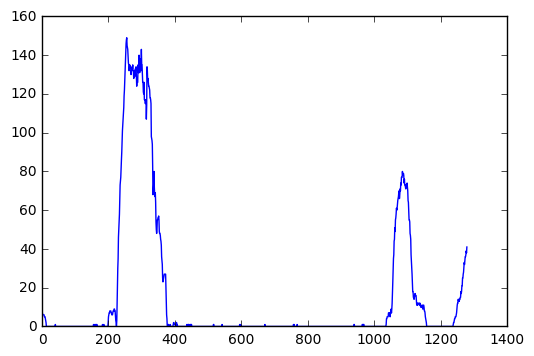

In [56]:
# import numpy as np
# print(binary_warped.shape[0]/2)
# print(np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0))
# histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# print(histogram[10])
# plt.plot(histogram)
# plt.show()